Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [3]:
#- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.

df['created_month'] = pd.DatetimeIndex(df.created).month 
df['created_year'] = pd.DatetimeIndex(df.created).year 
df['amenities'] = df[['fitness_center','roof_deck','dining_room',
                      'balcony','high_speed_internet','swimming_pool',
                      'terrace','exclusive','hardwood_floors','outdoor_space']].sum(axis =1)


testm = (df['created_month'] == 6) 
y2k16 = ( df['created_year'] == 2016)
trainm = (4 <= df['created_month']) & (df['created_month'] <= 5)
#bool filters
train = trainm & y2k16
test = testm & y2k16

df_train = df[train]
df_test  = df[test]

In [4]:
# Engineer at least two new features. (See below for explanation & ideas.)

df['bedbath'] = df.bathrooms * df.bedrooms           #did this last HW bathrooms alone was just as good..
df['l_offs'] = np.sqrt((40.753 - df.latitude)**2)    # how far is it off from the golden latitude  ##
df['day'] =  pd.DatetimeIndex(df.created).day      #



df[train].shape, df[test].shape
df.head()



,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,...,loft,garden_patio,wheelchair_access,common_outdoor_space,created_month,created_year,amenities,bedbath,l_offs,day
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,...,0,0,0,0,6,2016,0,4.5,0.0385,24
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,...,0,0,0,0,6,2016,1,2.0,0.0417,12
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,...,0,0,0,0,4,2016,1,1.0,0.0142,17
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,...,0,0,0,0,4,2016,1,1.0,0.0009,18
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,...,0,0,0,0,4,2016,0,4.0,0.0711,28


In [5]:
#explore features
import matplotlib.pyplot as plt

x= df.interest_level  # need to be encoded
x= df.description.str.len()  # 
x= df.wheelchair_access      # -
x= df.common_outdoor_space   #common 
x=pd.DatetimeIndex(df.created).hour  
x= df.loft              # - 
x0= df.bathrooms         #harder to manipulate bathrooms than bedrooms- need plumbing, permits etc etc
x= df.bedbath
y= df.price

fig = plt.figure(figsize=(7,7))
ax = plt.axes()
ax.scatter(x, y, alpha= .01, color = 'red')  #bedbath
ax.scatter(x0, y, alpha= .01)  # bathrooms alone


In [6]:
#Fit a linear regression model with at least two features.
from sklearn.linear_model import LinearRegression
model = LinearRegression()
features = ['longitude','latitude','bedbath']
features = ['bedbath','doorman']

target = ['price']
x_train = df[train][features]
y_train = df[train][target]

x_test = df[test][features]
y_test = df[test][target]
model.fit(x_train, y_train)        #crack! the model has been trained!
y_train_pred = model.predict(x_train)  
y_test_pred = model.predict(x_test)

model.coef_

array([[519.94030452, 843.45209495]])

In [7]:
#Get the model's coefficients and intercept.
print('coef array ', model.coef_ )
print('intercept', model.intercept_)

coef array  [[519.94030452 843.45209495]]
intercept [2112.95391258]


In [8]:
#Get regression metrics RMSE, MAE, and  𝑅2 , for both the train and test data.

#train 

from sklearn.metrics import mean_absolute_error,  mean_squared_error, r2_score
baseline = y_train.mean()
print('baseline', baseline)
mae = mean_absolute_error(y_train,  [baseline] * len(y_train))

print(f'Baseline Mean abs  Error rental price: {mae:.2f} percentage points!\n\n')

###train
mae = mean_absolute_error(y_train, y_train_pred)
print ('for features ',features)
print(f'training mae rental price: {mae:.2f} percentage points!')
y_pred = y_train_pred
y = y_train 
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)
print('R^2:', r2,'\n\n')

###Test
mae = mean_absolute_error(y_test, y_test_pred)
print(f'Test MAE rental price: {mae:.2f} percentage points!')  
y_pred = y_test_pred
y = y_test 

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)
print('R^2:', r2)

baseline price    3575.604007
dtype: float64
Baseline Mean abs  Error rental price: 1201.88 percentage points!


for features  ['bedbath', 'doorman']
training mae rental price: 785.99 percentage points!
Mean Squared Error: 1456797.1538163163
Root Mean Squared Error: 1206.978522516584
Mean Absolute Error: 785.99075841082
R^2: 0.530826436480603 


Test MAE rental price: 787.38 percentage points!
Mean Squared Error: 1427544.623915338
Root Mean Squared Error: 1194.7989889162686
Mean Absolute Error: 787.377895903015
R^2: 0.5406902009709614


In [9]:
ncols = df.select_dtypes(include=np.number).columns.tolist()
ncols.remove('price')
len(ncols)

34

In [12]:
##dont run, or change number of permutations to 2. 

ncols = df.select_dtypes(include=np.number).columns.tolist()
ncols.remove('price')

best_mae = mae 
target = ['price']
y_test = df[test][target]
y_train = df[train][target]

from itertools import permutations, combinations
fperms = combinations(ncols, 6)                                 
results= [[]]
for i in list(fperms):
    features = np.array(i)
    
    x_train = df[train][features]
    x_test = df[test][features]
    model.fit(x_train, y_train)        #crack! the model has been trained!
    y_train_pred = model.predict(x_train)  
    y_test_pred = model.predict(x_test)
    trainmae = mean_absolute_error(y_train, y_train_pred)
    testmae = mean_absolute_error(y_test, y_test_pred)
    
    results.append([features, testmae])
    if testmae < best_mae:
        best_mae = testmae  

###train
print ('for features: ',features)
print(f'training mae rental price: {trainmae:.2f} percentage points!')

###Test
print(f'best mae rental price: {best_mae:.2f} percentage points!')  #meh


for features:  ['created_month' 'created_year' 'amenities' 'bedbath' 'l_offs' 'day']
training mae rental price: 784.50 percentage points!
best mae rental price: 684.45 percentage points!


In [ ]:
res5 = pd.DataFrame(results,columns=['features', 'mean_abs_err'])


In [ ]:
res5.shape

#What's the best test MAE you can get? Share your score and features used with your cohort on Slack!

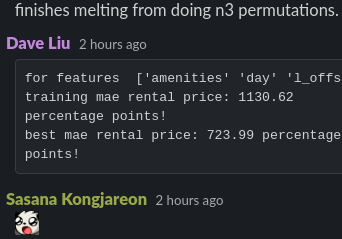
 #As always, commit your notebook to your fork of the GitHub repo.
![Selection_072.png](Selection_072.png)
    
    